In [1]:
import scanpy as sc

In [17]:
adata = sc.read("processed_files/dataset.h5ad")

In [4]:
adata = adata[adata.obs["cell_type"] == "glutamatergic neuron"]
adata.write("processed_files/glutamatergic.h5ad")

In [2]:
adata = sc.read("processed_files/glutamatergic.h5ad")

In [3]:
adata.layers["counts"] = adata.raw.X.copy()
adata.layers["logcounts"] = sc.pp.log1p(adata.layers["counts"]).copy()
adata.X = adata.layers["logcounts"].copy()

In [4]:
adata.layers["counts"] = adata.raw.X.copy()

In [5]:
sc.pp.highly_variable_genes(
    adata, n_top_genes=5000, subset=False
)

sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


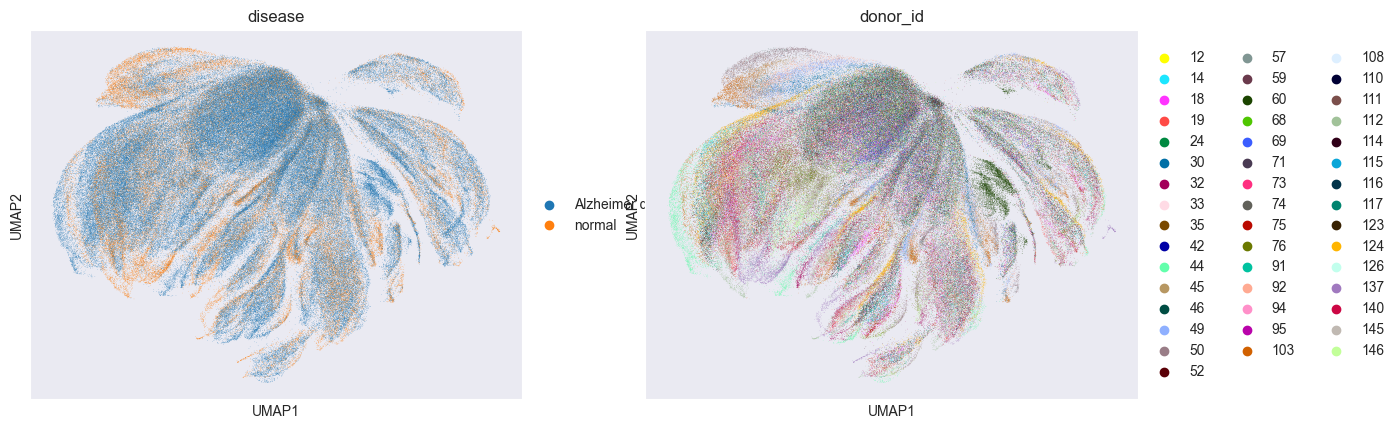

In [6]:
sc.pl.umap(adata, color=["disease", "donor_id"])

In [7]:
import scvi
import numpy as np

adata_scvi = adata[:, adata.var["highly_variable"]].copy()
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key="donor_id")
model_scvi = scvi.model.SCVI(adata_scvi)

max_epochs_scvi = int(np.min([round((200000 / adata.n_obs) * 400), 400]))
model_scvi.train(max_epochs=max_epochs_scvi, accelerator='gpu', early_stopping=True)
adata.obsm["X_scVI"] = model_scvi.get_latent_representation()

adata.write("processed_files/scvi_integration.h5ad")

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch/Jax operations are supported with this backend. as a result, some models might be slower and less accurate than usuall. Please verify your analysis!Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/shaunak/PycharmProjects/Single_Cell_Alzh

Epoch 283/283: 100%|██████████| 283/283 [6:49:36<00:00, 84.82s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.69e+3]    

`Trainer.fit` stopped: `max_epochs=283` reached.


Epoch 283/283: 100%|██████████| 283/283 [6:49:36<00:00, 86.84s/it, v_num=1, train_loss_step=1.72e+3, train_loss_epoch=1.69e+3]


In [1]:
import scanpy as sc
adata = sc.read("processed_files/scvi_integration.h5ad")
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

Python(91096) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


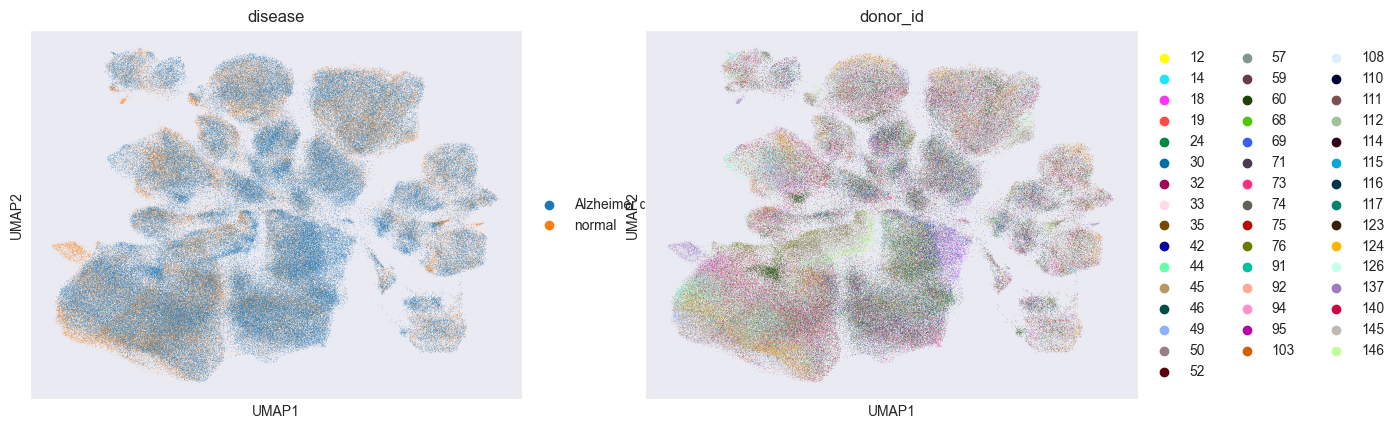

In [2]:
sc.pl.umap(adata, color=["disease", "donor_id"])

In [3]:
import pertpy as pt

milo = pt.tl.Milo()
mdata = milo.load(adata)
mdata

MuData object with n_obs × n_vars = 282930 × 61427
  2 modalities
    rna:	282930 x 61427
      obs:	'APOE_class', 'Brain.Region', 'SORT', 'Braak.stage', 'Disease.Group', 'Amyloid', 'Brain.weight', 'PMI.hr.', 'Race', 'Age', 'RIN', 'total_counts', 'pct_counts_mt', 'droplet_FDR', 'doublefinder', 'n_genes', 'sample', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'donor_id', 'Age_group', 'PMI_group', 'RIN_group', 'Major_celltypes', 'Author_Annotation', 'NP.Diagonis', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
      var:	'mt', 'ribo', 'hb', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'Amyloid_colors', 'Author_Annotation_colors', 'Braak.stage_colors', 'Brain.Region_colors', 'cell_type_colors', 'citation', 'disease_colors', 'donor_id_colors', 'hvg', 'neighbors', 'organism', 'organism_ontology_term_id', 'pca', 'schema_reference', 'schema_version', 'title', 'umap'
      obsm:	'X_pca', 'X_pca_harmony', 'X_scVI', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'logcounts', 'spliced', 'unspliced'
      obsp:	'connectivities', 'distances'
    milo:	0 x 0

In [4]:
## Stable parameters are k = 5 * donors, prop = 0.05

k = len(set(adata.obs["donor_id"])) * 5
sc.pp.neighbors(adata, n_neighbors=k, use_rep="X_scVI", key_added="milo")

In [32]:
milo.make_nhoods(mdata, neighbors_key="milo", prop=0.02)

Text(0, 0.5, '# neighbouthoods')

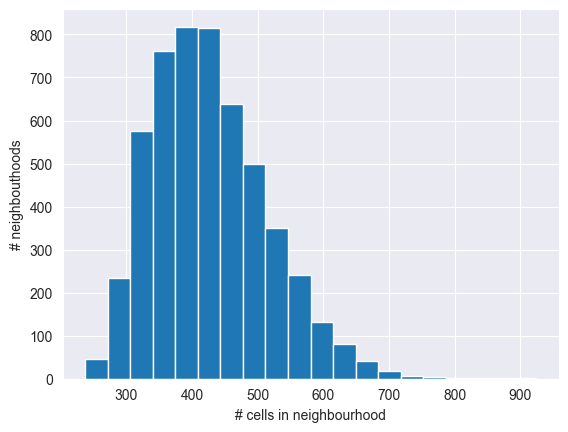

In [33]:
import matplotlib.pyplot as plt

nhood_size = adata.obsm["nhoods"].toarray().sum(0)
plt.hist(nhood_size, bins=20)
plt.xlabel("# cells in neighbourhood")
plt.ylabel("# neighbouthoods")

Text(0, 0.5, 'Mean # cells per sample in nhood')

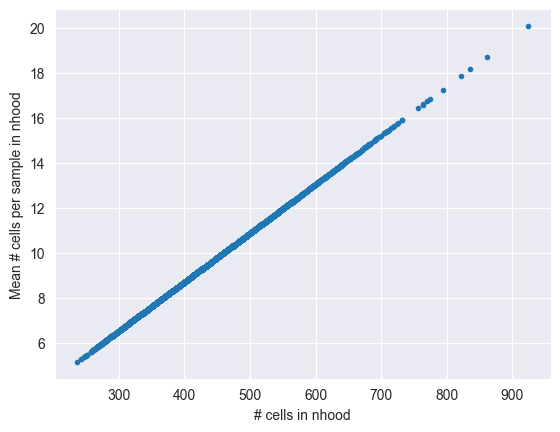

In [34]:
milo.count_nhoods(mdata, sample_col="donor_id")

mean_n_cells = mdata["milo"].X.toarray().mean(0)
plt.plot(nhood_size, mean_n_cells, ".")
plt.xlabel("# cells in nhood")
plt.ylabel("Mean # cells per sample in nhood")

In [35]:
adata.obs["disease"].unique()
adata.obs["disease"] = adata.obs["disease"].str.replace(" ", "_")

In [36]:
milo.da_nhoods(
    mdata, design="~disease", model_contrasts="diseaseAlzheimer_disease-diseasenormal"
)
milo_results_salmonella = mdata["milo"].obs.copy()
milo_results_salmonella

,disease,donor_id
12,Alzheimer_disease,12
14,Alzheimer_disease,14
18,Alzheimer_disease,18
19,Alzheimer_disease,19
24,Alzheimer_disease,24
30,Alzheimer_disease,30
32,Alzheimer_disease,32
33,Alzheimer_disease,33
35,Alzheimer_disease,35
42,Alzheimer_disease,42


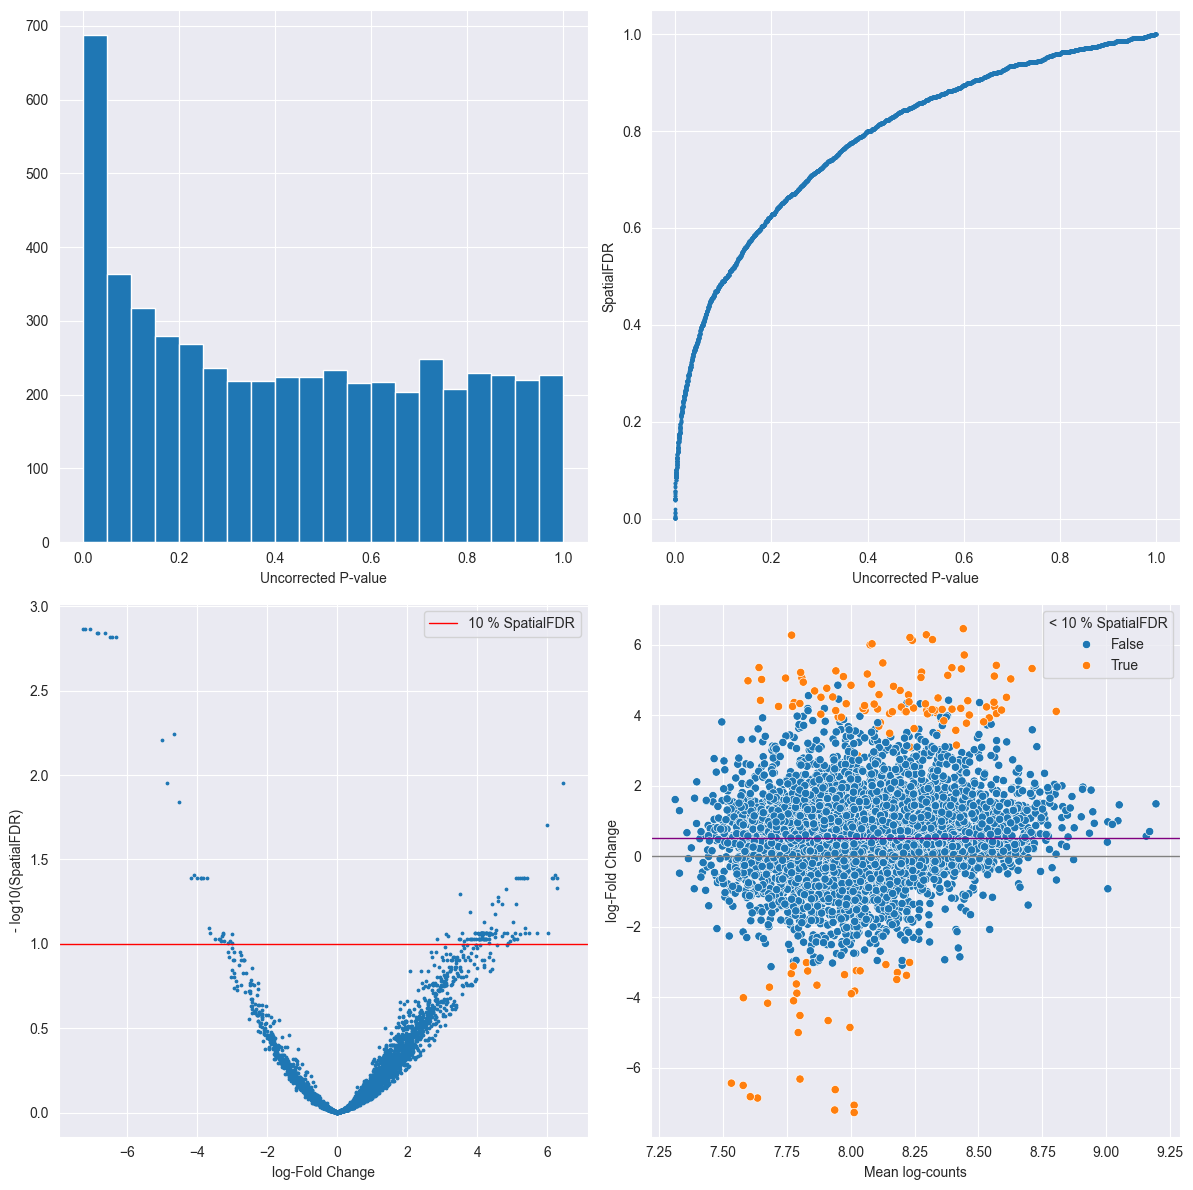

In [37]:
import matplotlib
import seaborn as sns
import numpy as np

def plot_milo_diagnostics(mdata):
    alpha = 0.1  ## significance threshold

    with matplotlib.rc_context({"figure.figsize": [12, 12]}):
        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(mdata["milo"].var["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(
            mdata["milo"].var["PValue"],
            mdata["milo"].var["SpatialFDR"],
            s=3,
        )
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            mdata["milo"].var["logFC"],
            -np.log10(mdata["milo"].var["SpatialFDR"]),
            s=3,
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = mdata["milo"].var
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()


plot_milo_diagnostics(mdata)

/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/shaunak/PycharmProjects/Single_Cell_Alzheimers/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1158: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


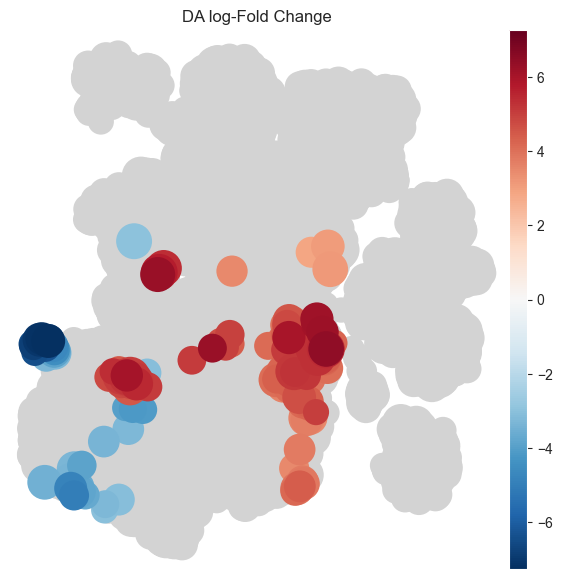

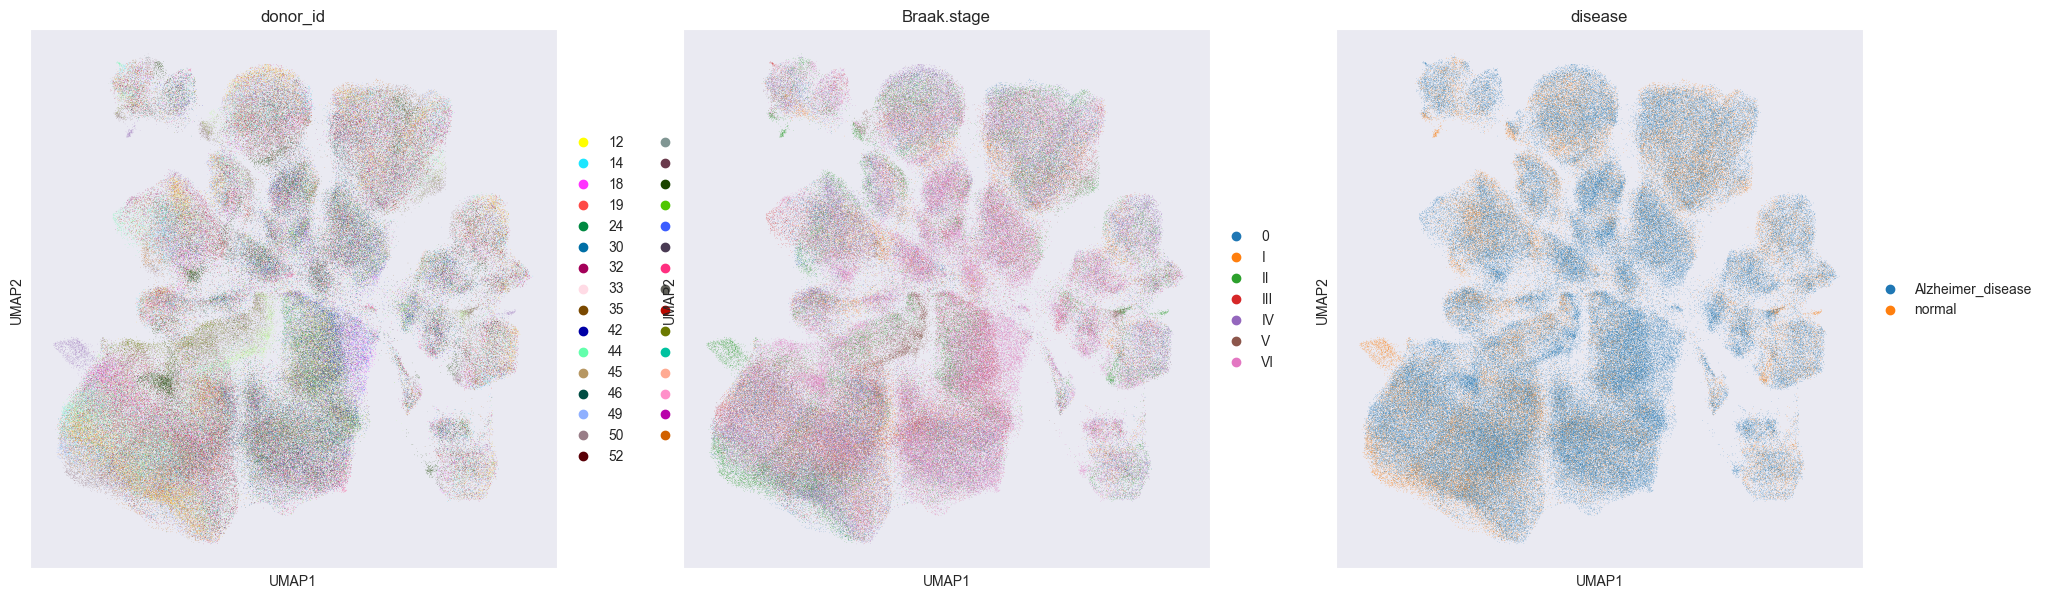

In [60]:
milo.build_nhood_graph(mdata)
with matplotlib.rc_context({"figure.figsize": [7, 7]}):
    milo.plot_nhood_graph(mdata, alpha=0.1, min_size=5, plot_edges=False)
    sc.pl.umap(mdata["rna"], color=["donor_id", "Braak.stage", "disease"])

In [57]:
significant_index_cells = mdata["milo"].var[mdata['milo'].var["SpatialFDR"] < 0.1]

In [58]:
import pandas as pd

cluster_index =significant_index_cells.index

df_sparse = pd.DataFrame.sparse.from_spmatrix(
    adata.obsm["nhoods"],
    index=adata.obs_names,
    columns=[f"{i}" for i in range(adata.obsm["nhoods"].shape[1])]
)

In [59]:
for idx in cluster_index:
    items = df_sparse[df_sparse[idx] == 1]
    adata[items.index].write(f"processed_files/significant_subpopulation/cluster" + idx + ".h5ad")

In [56]:
adata.write("processed_files/nearest_neighbours.h5ad")